In [1]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

In [2]:
import os
print(os.getcwd())

/Users/luck1226/Py/ML/Doubly-Stochastic-DGP-master/demos


In [3]:
import numpy as np
import tensorflow as tf

# plotting
import matplotlib.pyplot as plt
import matplotlib.animation as manimation
# FFMpegWriter = manimation.writers['ffmpeg'] # this only work on mac for me

from gpflow import Param
from gpflow import autoflow, params_as_tensors
from gpflow import settings
from gpflow.mean_functions import Zero, Linear
from gpflow.likelihoods import Gaussian as Gaussian_lik
from gpflow.kernels import RBF, White
from gpflow.kernels import Kernel

# dgp imports 
os.chdir('/Users/luck1226/Py/ML/Doubly-Stochastic-DGP-master')

from doubly_stochastic_dgp.dgp import DGP

figs_dir = './dgp_videos'
#import os
if not os.path.isdir(figs_dir):
    os.mkdir(figs_dir)
    
np.random.seed(0)

In [4]:
num_frames = 240
great_cirlce_its = 120
fps = 40

In [5]:
def mackay_sample(v, c=0.99):
    # p 551 of the MacKay information theory book 
    s = (1-c**2)**0.5
    return c*v + s*np.random.randn(*v.shape)

In [6]:
class GreatCircleWithMacKay(object):
    def __init__(self, shape, increments, c= 0.9999):
        self.N, self.D = shape
        self.u = np.random.randn(self.N, self.D)
        self.v_ = np.random.uniform(-1, 1, self.D*(self.N-1)).reshape(self.N-1, self.D)
        self.increments = np.random.uniform(increments, 2*increments, self.D).reshape(1, 1, self.D)
        self.i = 0.
        self.c = c
    
    def compute_rotation_matrix(self, u, v):
        # https://math.stackexchange.com/questions/197772/generalized-rotation-matrix-in-n-dimensional-space-around-n-2-unit-vector
        r = -(np.sum(u[:-1] * v, 0))/u[-1, :]
        v = np.concatenate([v, r.reshape(1, self.D)], 0)

        ed = np.expand_dims
        v_ = v/ed(np.sum(v**2, 0)**0.5, 0)
        u_ = u / ed(np.sum(u**2, 0)**0.5, 0)

        R1 = ed(np.eye(self.N), -1) # NND
        R2 = ed(v_, 1) * ed(u_, 0) - ed(v_, 0) * ed(u_, 1)
        R3 = ed(u_, 1) * ed(u_, 0) + ed(v_, 1) * ed(v_, 0)
        return R1, R2, R3
        
    def sample(self):
        s = np.sin(2*np.pi*self.i/self.increments)
        c = np.cos(2*np.pi*self.i/self.increments)
        
        # move around both the starting vector and the rotation vector
        self.u = mackay_sample(self.u, c=self.c)

        R1, R2, R3 = self.compute_rotation_matrix(self.u, self.v_)
        R = R1 + s * R2 + (c - 1) * R3
        
        self.i += 1
        
        return np.einsum('nNd,Nd->nd', R, self.u)

In [7]:
class DGP_with_z(DGP):
    """
    A slight modification so that when we predict all layer we can pass in the z points, 
    rather than sampling them each time. This allow us to plot correlated samples. 
    """
    def __init__(self, *args, **kw):
        DGP.__init__(self, *args, **kw)
        # ugly slicing  
        self.starts = [0,]
        self.ends = [self.layers[0].q_mu.shape[1], ]
        for layer in self.layers[1:]:
            #layer.mean_function = Linear(A=np.eye(layer.kern.input_dim))  # explict linear rather than identity 
            layer.mean_function = Zero()
            d = layer.q_mu.shape[1]
            self.starts.append(self.starts[-1] + d)
            self.ends.append(self.ends[-1] + d)
    
            
            
    @params_as_tensors
    @autoflow((settings.float_type, [None, None]), (settings.float_type, [None, None, None]))
    def predict_all_layers_full_cov_with_z(self, Xnew, z):
        zs = []
        for s, e in zip(self.starts, self.ends):
            zs.append(z[:, :, s:e])
        return self.propagate(Xnew, full_cov=True, zs=zs, S=tf.shape(z)[0])
    

In [8]:
class Stationary_tmp(Kernel):
    
    #def __init__(self):
    #    super().__init__(input_dim=1, active_dims=[0])
    #    self.variance = gpflow.Param(1.0, transform=gpflow.transforms.positive)
    #    self.lengthscales = gpflow.Param(1.0, transform=gpflow.transforms.positive)
     
    def __init__(self, input_dim, variance=1.0, lengthscales=1.0,
                 active_dims=None, ARD=None, name=None):
        """
        - input_dim is the dimension of the input to the kernel
        - variance is the (initial) value for the variance parameter
        - lengthscales is the initial value for the lengthscales parameter
          defaults to 1.0 (ARD=False) or np.ones(input_dim) (ARD=True).
        - active_dims is a list of length input_dim which controls which
          columns of X are used.
        - if ARD is not None, it specifies whether the kernel has one
          lengthscale per dimension (ARD=True) or a single lengthscale
          (ARD=False). Otherwise, inferred from shape of lengthscales.
        """
        super().__init__(input_dim, active_dims, name=name)
        #self.variance = Param(variance, transform=gpflow.transforms.positive)
        self.variance = Param(variance)

        #lengthscales, self.ARD = self._validate_ard_shape("lengthscales", lengthscales, ARD)
        #self.lengthscales = Param(lengthscales, transform=gpflow.transforms.positive)
        self.lengthscales = Param(lengthscales)
    
    @params_as_tensors
    def _scaled_square_dist(self, X, X2):
        """
        Returns ((X - X2ᵀ)/lengthscales)².
        Due to the implementation and floating-point imprecision, the
        result may actually be very slightly negative for entries very
        close to each other.

        This function can deal with leading dimensions in X and X2. 
        In the sample case, where X and X2 are both 2 dimensional, 
        for example, X is [N, D] and X2 is [M, D], then a tensor of shape 
        [N, M] is returned. If X is [N1, S1, D] and X2 is [N2, S2, D] 
        then the output will be [N1, S1, N2, S2].
        """

        X = X / self.lengthscales

        if X2 is None:
            Xs = tf.reduce_sum(tf.square(X), axis=-1, keepdims=True)
            dist = -2 * tf.matmul(X, X, transpose_b=True)
            dist += Xs + tf.matrix_transpose(Xs)
            return dist

        Xs = tf.reduce_sum(tf.square(X), axis=-1)
        X2 = X2 / self.lengthscales
        X2s = tf.reduce_sum(tf.square(X2), axis=-1)
        dist = -2 * tf.tensordot(X, X2, [[-1], [-1]])
        dist += _broadcasting_elementwise_op(tf.add, Xs, X2s)
        return dist
    
    @staticmethod
    def _clipped_sqrt(r2):
        # Clipping around the (single) float precision which is ~1e-45.
        return tf.sqrt(tf.maximum(r2, 1e-40))

    def scaled_square_dist(self, X, X2):  # pragma: no cover
        return self._scaled_square_dist(X, X2)

    def scaled_euclid_dist(self, X, X2):  # pragma: no cover
        """
        Returns |(X - X2ᵀ)/lengthscales| (L2-norm).
        """
        warnings.warn('scaled_euclid_dist is deprecated and will be removed '
                      'in GPflow version 1.4.0. For stationary kernels, '
                      'define K_r(r) instead.',
                      DeprecationWarning)
        r2 = self.scaled_square_dist(X, X2)
        return self._clipped_sqrt(r2)



    @params_as_tensors
    def Kdiag(self, X, presliced=False):
        return tf.fill(tf.shape(X)[:-1], tf.squeeze(self.variance))

    @params_as_tensors
    def K(self, X, X2=None, presliced=False):
        """
        Calculates the kernel matrix K(X, X2) (or K(X, X) if X2 is None).
        Handles the slicing as well as scaling and computes k(x, x') = k(r),
        where r² = ((x - x')/lengthscales)².

        Internally, this calls self.K_r2(r²), which in turn computes the
        square-root and calls self.K_r(r). Classes implementing stationary
        kernels can either overwrite `K_r2(r2)` if they only depend on the
        squared distance, or `K_r(r)` if they need the actual radial distance.
        """
        if not presliced:
            X, X2 = self._slice(X, X2)
        return self.K_r2(self.scaled_square_dist(X, X2))
    
    def K_r2(self, r2):
        """
        Returns the kernel evaluated on `r2`, which is the scaled squared distance.
        Will call self.K_r(r=sqrt(r2)), or can be overwritten directly (and should operate element-wise on r2).
        """
        r = self._clipped_sqrt(r2)
        return self.K_r(r)
    
    def K_r2(self, r2):
        r = self._clipped_sqrt(r2)
        return self.K_r(r)
        

def _broadcasting_elementwise_op(op, a, b):
    r"""
    Apply binary operation `op` to every pair in tensors `a` and `b`.
    :param op: binary operator on tensors, e.g. tf.add, tf.substract
    :param a: tf.Tensor, shape [n_1, ..., n_a]
    :param b: tf.Tensor, shape [m_1, ..., m_b]
    :return: tf.Tensor, shape [n_1, ..., n_a, m_1, ..., m_b]
    """
    flatres = op(tf.reshape(a, [-1, 1]), tf.reshape(b, [1, -1]))
    return tf.reshape(flatres, tf.concat([tf.shape(a), tf.shape(b)], 0))
        
class SE_SE(Stationary_tmp):
    
    def __init__(self,input_dim,variance1=1.0, ell1=1.0, var0=1.0, ell0=1.0):
        
        super().__init__(input_dim = input_dim, lengthscales=ell0, variance = var0)
        #self.variance1 = Param(variance1, transform=gpflow.transforms.positive)
        self.variance1 = Param(variance1)
        self.ell1 = Param(ell1)
        #self.lengthscales1 = gpflow.Param(lengthscales1, transform=gpflow.transforms.positive)
    
    #    self.variance1 = gpflow.Param(1.0, transform=gpflow.transforms.positive)
    #    self.len_over_var0 = gpflow.Param(1.5, transform=gpflow.transforms.positive)
    #@staticmethod
    #def tmp1(self, r2):
    #    return 2.0 * (self.variance/self.lengthscales1)**2 * (1.0 - tf.exp(-r2 / 2.))
    
    @params_as_tensors
    def K_r2(self, r2):
        tmp = 2.0 * tf.pow(self.variance/self.ell1, 2) * (1.0 - tf.exp(-r2 / 2.))
        return tf.pow(self.variance1, 2) * tf.pow(1 + tmp, -0.5)

In [9]:
def plot_prior(model, z, axs):
    Fs, ms, Ks = m.predict_all_layers_full_cov_with_z(Xs, z)
    
    L = len(model.layers)
    axs_ = (axs, ) if L == 1 else axs

    S = z.shape[0]
    sXs = np.tile(Xs[None, :, :], [S, 1, 1])
    for i, (F_in, F_out, K, (ax1, ax2, ax3)) in enumerate(zip([sXs]+Fs[:-1], Fs, Ks, axs_)):
        
        ax1.plot(Xs.flatten(), F_in[0, :, 0], color='C0')
        ax2.imshow(K[0, :, :, 0], aspect="auto")
        ax2.set_yticklabels([])
        ax2.set_xticklabels([])

        ax3.plot(Xs.flatten(), F_out[:, :, 0].T, alpha=0.3)
        ax3.plot(Xs.flatten(), F_out[0, :, 0], alpha=1.)
#         ax3.plot(Xs.flatten(), , color='C0')
        
        for ax in [ax1, ax3]:
            ax.set_xlim(min(Xs), max(Xs))
            ax.set_ylim(-2, 2)
        
        ax1.set_title('layer {} input'.format(i+1))
        ax2.set_title('layer {} covariance'.format(i+1))
        ax3.set_title('layer {} sample outputs'.format(i+1))

def setup_fig(m):
    L = len(m.layers)
    fig, axs = plt.subplots(L, 3, figsize=(15, L*5))
    return fig, axs

def plot_single_frame(model, S=5, name='test'):
    fig, axs = setup_fig(m)
    z = np.random.randn(S, len(Xs), len(model.layers))
    plot_prior(model, z, axs)
#     plt.savefig(figs_dir + "/new_{}.pdf".format(name))
    plt.show()
    
def plot_video(model, S=5, num_frames=num_frames, great_cirlce_its=great_cirlce_its, fps=fps, name='test'):
    
    gc_z = GreatCircleWithMacKay((S, len(Xs), len(model.layers)), great_cirlce_its)

    writer = FFMpegWriter(fps=fps, bitrate=100*fps)
    fig, axs = setup_fig(model)

    def make_frame(n):
        z = gc_z.sample()
    
        for ax in axs.ravel():
            plt.sca(ax)
            plt.cla()

        plot_prior(model, z, axs)

        plt.draw()
        writer.grab_frame()

    anim = manimation.FuncAnimation(fig, make_frame, frames=num_frames)
#     anim.save(figs_dir + "/new_{}.mp4".format(name), writer=writer)

In [10]:
Ns = 300
Xs = np.linspace(-2, 2, Ns).reshape(-1, 1)
X = np.zeros((1, 1))

#kerns_1 = [RBF(1, lengthscales=0.3)]

kerns_1 = [SE_SE(input_dim=1, variance1 = 0.5, ell1 = 0.9, var0 = 0.5, ell0=0.5)]

kerns_2 = [RBF(1, lengthscales=0.5, variance = 0.5), 
           RBF(1, lengthscales=0.9, variance = 0.5)]

m_dgp_1 = DGP_with_z(X, X, X, kerns_1, Gaussian_lik())
m_dgp_2 = DGP_with_z(X, X, X, kerns_2, Gaussian_lik())


Instructions for updating:
Colocations handled automatically by placer.


Instructions for updating:
Colocations handled automatically by placer.


1 1


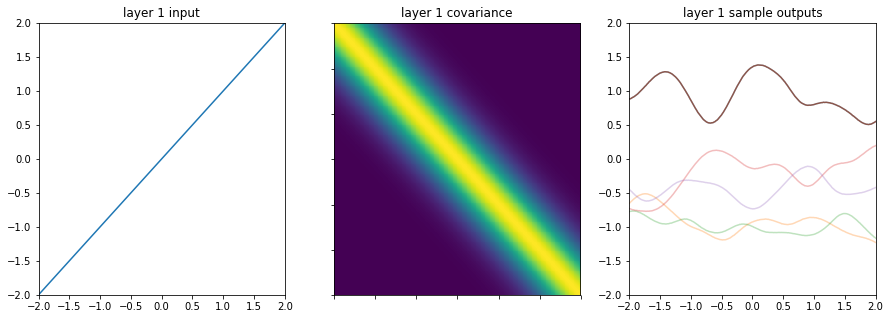

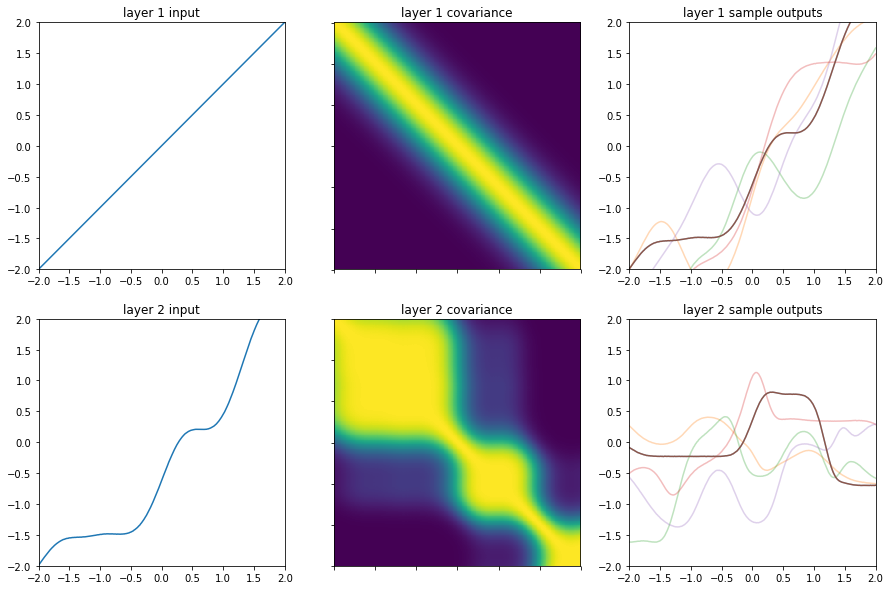

In [11]:
# zero mean function
#for m in[m_dgp_2]:
#    for layer in m.layers[:-1]:
        #layer.mean_function.A = np.zeros((1, 1))
#        print(layer.mean_function()) 

for m in [m_dgp_1]:
    plot_single_frame(m, name='{}_layer'.format(len(m.layers)))
#     plot_video(m, name='{}_layer'.format(len(m.layers)))

# zero mean function with small outputs
#for m in [m_dgp_2]:
#    for layer in m.layers[:-1]:
#        layer.kern.variance = 0.2
        
for m in [m_dgp_2]:
    plot_single_frame(m, name='{}_layer_small'.format(len(m.layers)))
#     plot_video(m, name='{}_layer_small'.format(len(m.layers)))



In [12]:
from gpflow.models.sgpr import GPRFITC

from gpflow.training import AdamOptimizer, ScipyOptimizer, NatGradOptimizer
from gpflow.actions import Action, Loop

from scipy.cluster.vq import kmeans2
from scipy.stats import norm
from scipy.special import logsumexp

In [13]:
print(os.getcwd())
from datasets import Datasets
datasets = Datasets(data_path='/Users/luck1226/Py/ML/Doubly-Stochastic-DGP-master/data/')

/Users/luck1226/Py/ML/Doubly-Stochastic-DGP-master


In [14]:
data = datasets.all_datasets['kin8nm'].get_data()
X, Y, Xs, Ys, Y_std = [data[_] for _ in ['X', 'Y', 'Xs', 'Ys', 'Y_std']]
print('N: {}, D: {}, Ns: {}'.format(X.shape[0], X.shape[1], Xs.shape[0]))

N: 7372, D: 8, Ns: 820


In [15]:
def make_single_layer_models(X, Y, Z):
    D = X.shape[1]
    #m_sgpr = SGPR(X, Y, RBF(D), Z.copy())
    #m_svgp = SVGP(X, Y, RBF(D), Gaussian(), Z.copy())
    m_fitc = GPRFITC(X[0:150,:], Y[0:150], RBF(input_dim = D), Z.copy())
    #m_fitc = GPRFITC(X, Y, SE_SE(input_dim = D), Z.copy())
    #for m in m_fitc:
    m_fitc.likelihood.variance = 0.01
    return m_fitc

Z_100 = kmeans2(X, 100, minit='points')[0]
models_single_layer = make_single_layer_models(X, Y, Z_100)

In [16]:
def batch_assess(model, assess_model, X, Y):
    n_batches = max(int(X.shape[0]/1000.), 1)
    lik, sq_diff = [], []
    for X_batch, Y_batch in zip(np.array_split(X, n_batches), np.array_split(Y, n_batches)):
        l, sq = assess_model(model, X_batch, Y_batch)
        lik.append(l)
        sq_diff.append(sq)
    lik = np.concatenate(lik, 0)
    sq_diff = np.array(np.concatenate(sq_diff, 0), dtype=float)
    return np.average(lik), np.average(sq_diff)**0.5

def assess_single_layer(model, X_batch, Y_batch):
    m, v = model.predict_y(X_batch)
    lik = np.sum(norm.logpdf(Y_batch*Y_std, loc=m*Y_std, scale=Y_std*v**0.5),  1)
    sq_diff = Y_std**2*((m - Y_batch)**2)
    return lik, sq_diff 

S = 100
def assess_sampled(model, X_batch, Y_batch):
    m, v = model.predict_y(X_batch, S)
    S_lik = np.sum(norm.logpdf(Y_batch*Y_std, loc=m*Y_std, scale=Y_std*v**0.5), 2)
    lik = logsumexp(S_lik, 0, b=1/float(S))
    
    mean = np.average(m, 0)
    sq_diff = Y_std**2*((mean - Y_batch)**2)
    return lik, sq_diff

In [17]:
iterations_few = 100
iterations_many = 500
s = '{:<16}  lik: {:.4f}, rmse: {:.4f}'

ScipyOptimizer().minimize(models_single_layer, maxiter=iterations_few)
lik, rmse = batch_assess(models_single_layer, assess_single_layer, Xs, Ys)
print(s.format('FITC', lik, rmse))

Instructions for updating:
Use tf.cast instead.


Instructions for updating:
Use tf.cast instead.


INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: 122.410520
  Number of iterations: 100
  Number of functions evaluations: 104


INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: 122.410520
  Number of iterations: 100
  Number of functions evaluations: 104


FITC              lik: 0.3258, rmse: 0.1700


In [18]:
from gpflow.models.gpr import GPR

In [103]:
m_GPR = GPR(X[0:500,:],Y[0:500],kern = SE_SE(input_dim = X.shape[1]))

In [104]:
m_GPR.likelihood.variance = 0.01

In [105]:
opt = ScipyOptimizer()
opt.minimize(m_GPR)

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 438.499640
  Number of iterations: 36
  Number of functions evaluations: 42


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 438.499640
  Number of iterations: 36
  Number of functions evaluations: 42


In [106]:
m_GPR_rbf = GPR(X[0:500,:],Y[0:500],kern = RBF(input_dim = X.shape[1]))
m_GPR_rbf.likelihood.variance = 0.01
opt.minimize(m_GPR_rbf)

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 435.180119
  Number of iterations: 19
  Number of functions evaluations: 25


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 435.180119
  Number of iterations: 19
  Number of functions evaluations: 25


In [107]:
print(m_GPR)

                             class prior transform  trainable shape  \
GPR/kern/ell1            Parameter  None    (none)       True    ()   
GPR/kern/lengthscales    Parameter  None    (none)       True    ()   
GPR/kern/variance        Parameter  None    (none)       True    ()   
GPR/kern/variance1       Parameter  None    (none)       True    ()   
GPR/likelihood/variance  Parameter  None       +ve       True    ()   

                         fixed_shape               value  
GPR/kern/ell1                   True  1.6670582981946878  
GPR/kern/lengthscales           True   1.831616579040321  
GPR/kern/variance               True  0.4317445242521538  
GPR/kern/variance1              True   4.157784719646192  
GPR/likelihood/variance         True   0.053648949911204  


In [108]:
print(m_GPR_rbf)

                             class prior transform  trainable shape  \
GPR/kern/lengthscales    Parameter  None       +ve       True    ()   
GPR/kern/variance        Parameter  None       +ve       True    ()   
GPR/likelihood/variance  Parameter  None       +ve       True    ()   

                         fixed_shape                 value  
GPR/kern/lengthscales           True    1.7575526604771923  
GPR/kern/variance               True    1.0345431921391988  
GPR/likelihood/variance         True  0.061109063683891365  


In [109]:
pred_y = m_GPR_rbf.predict_y(Xs)

In [110]:
pred_y1 = m_GPR.predict_y(Xs)

In [111]:
rms1 = np.sqrt(np.mean((pred_y[0]-Ys)**2))
rms2 = np.sqrt(np.mean((pred_y1[0]-Ys)**2))

print(rms1)
print(rms2)

0.44822977433175304
0.44912681538938853
